In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import xarray as xr
import textwrap
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid

In [2]:
# figure root
fig_root = os.environ['HOME']+'/work/E3SMv1_Future_Projection/figures'
save_fig = True

In [3]:
datadir     = os.environ['HOME']+'/data/cmip6/e3sm/mpas_analysis'
histdir     = datadir+'/20180215.DECKv1b_H1.ne30_oEC.edison'
histdir_ghg = datadir+'/20190404.DECKv1b_H1_hist-GHG.ne30_oEC.edison'
projdir     = datadir+'/20190807.DECKv1b_P1_SSP5-8.5.ne30_oEC.cori-knl'
projdir_ghg = datadir+'/20191019.DECKv1b_P1_SSP5-8.5-GHG.ne30_oEC.cori-knl'
climdir     = '/clim/mpas/avg/remapped'
hist_season_jas = 'JAS_198507_201409'
hist_season_jfm = 'JFM_198501_201403'
proj_season_jas = 'JAS_207007_209909'
proj_season_jfm = 'JFM_207001_209903'

In [37]:
def get_diff_clim(var, varname, histdir, projdir, climdir, hist_season, proj_season):
    hist = histdir+climdir+'/'+var+'/mpascice_'+hist_season+'_climo.nc'
    proj = projdir+climdir+'/'+var+'/mpascice_'+proj_season+'_climo.nc'
    with xr.open_dataset(hist) as ds:
        hist_da = ds.data_vars[varname]
    with xr.open_dataset(proj) as ds:
        proj_da = ds.data_vars[varname]
        diff_da = (proj_da - hist_da)/hist_da
#         diff_da.attrs['units'] = hist_da.attrs['units']
#         diff_da.attrs['long_name'] = '$\Delta $'+hist_da.attrs['long_name']
    return diff_da

def plot_diff_clim(diff_da, cmap = 'viridis', levels=None, ax=None, colorbar=True, **kwargs):
    if ax is None:
        ax = plt.gca()
    m = Basemap(projection='npstere', boundinglat=50, lon_0=0,
                resolution='l', ax=ax)
    # plot coastlines, draw label meridians and parallels.
    m.drawcoastlines(zorder=3)
    m.drawmapboundary(fill_color='lightgray')
    m.fillcontinents(color='gray',lake_color='lightgray', zorder=2)
    m.drawparallels(np.arange(-80.,81.,10.), labels=[0,0,0,0])
    m.drawmeridians(np.arange(-180.,181.,20.), labels=[1,1,1,1])
    data = diff_da.data
    lon = diff_da.lon.data
    lat = diff_da.lat.data 
    data, lon = shiftgrid(20., data, lon, start=True, cyclic=360.)
    lon2d, lat2d = np.meshgrid(lon, lat)
    if levels is not None:
        bounds = np.array(levels)
        norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)
    else:
        norm = None
    xx, yy = m(lon2d, lat2d)
    fig = m.contourf(xx, yy, data, levels=levels, extend='both',
                     norm=norm, cmap=plt.cm.get_cmap(cmap), **kwargs)
    # add colorbar
    if colorbar:
        cb = m.colorbar(fig, ax=ax)
        cb_label = '\n'.join(textwrap.wrap('{} ({})'.format(diff_da.attrs['long_name'], 
                                                            diff_da.attrs['units']), 30))
        cb.set_label(cb_label)
        cb.formatter.set_powerlimits((-4, 4)) 
        cb.update_ticks()
    return fig
    
def plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg,
                      levels, cblabel):
    fig, axarr = plt.subplots(2, 2)
    fig.set_size_inches([9, 7])
    im = plot_diff_clim(diff_jfm_da, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[0,0])
    plot_diff_clim(diff_jas_da, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[1,0])
    plot_diff_clim(diff_jfm_da_ghg, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[0,1])
    plot_diff_clim(diff_jas_da_ghg, levels=levels, cmap='RdBu_r', colorbar=False, ax=axarr[1,1])
    axarr[0,0].set_title('All forcing')
    axarr[0,1].set_title('GHG only')
    axarr[0,0].text(0.05, 0.75, '(a) JFM', transform=axarr[0,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[0,1].text(0.05, 0.75, '(b) JFM', transform=axarr[0,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,0].text(0.05, 0.75, '(c) JAS', transform=axarr[1,0].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    axarr[1,1].text(0.05, 0.75, '(d) JAS', transform=axarr[1,1].transAxes,
                    fontsize=11, color='k', fontweight='bold', va='top',
                    bbox=dict(boxstyle="square",ec='k',fc='w'))
    # reduce margin
    plt.tight_layout()

    # colorbar
    plt.subplots_adjust(right=0.88, left=0.05)
    plt.subplots_adjust(top=0.9)
    cax = plt.axes([0.82, 0.05, 0.1, 0.9])
    cax.set_visible(False)
    cb = plt.colorbar(im, ax=cax)
    cb.set_label(cblabel)
    return fig

In [38]:
var = 'seaIceConcNH_oEC60to30v3_to_0.5x0.5degree'
varname = 'timeMonthly_avg_iceAreaCell'
diff_jas_da = get_diff_clim(var, varname, histdir, projdir, climdir, hist_season_jas, proj_season_jas)
diff_jfm_da = get_diff_clim(var, varname, histdir, projdir, climdir, hist_season_jfm, proj_season_jfm)
diff_jas_da_ghg = get_diff_clim(var, varname, histdir_ghg, projdir_ghg, climdir, hist_season_jas, proj_season_jas)
diff_jfm_da_ghg = get_diff_clim(var, varname, histdir_ghg, projdir_ghg, climdir, hist_season_jfm, proj_season_jfm)


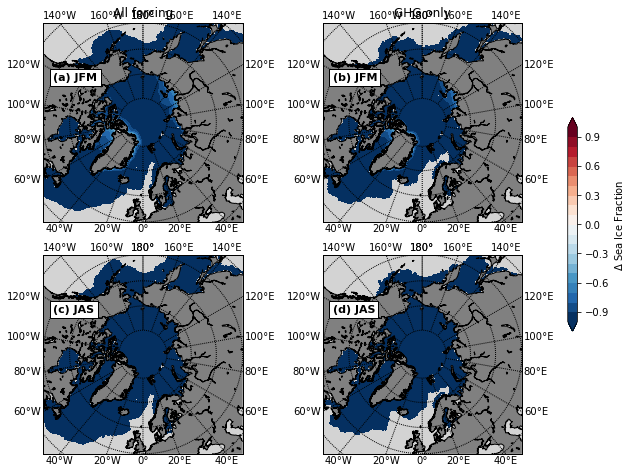

In [39]:
levels = np.linspace(-1, 1, 21)
cblabel= '$\Delta$ Sea Ice Fraction'
fig = plot_diff_clim_all(diff_jfm_da, diff_jas_da, diff_jfm_da_ghg, diff_jas_da_ghg, levels, cblabel)
if save_fig:
    figname = fig_root+'/CMIP6_ScenarioMIP_Map_iFrac.png'
    fig.savefig(figname, dpi = 300)